# Classification of the segmentations

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import monai
from PIL import Image
import torch
import wandb
import nibabel as nib
import scipy.ndimage as ndi
from monai.config import print_config
from monai.utils import first
from monai.config import KeysCollection
from monai.data import Dataset, ArrayDataset, create_test_image_3d, DataLoader
from monai.transforms import (
    Transform,
    MapTransform,
    Randomizable,
    AddChannel,
    AddChanneld,
    CastToTyped,
    Compose,
    LoadImage,
    LoadImaged,
    Lambda,
    Lambdad,
    RandSpatialCrop,
    RandSpatialCropd,
    Resize,
    ToTensor,
    ToTensord,
    Orientation, 
    Rotate,
    RandFlipd,
    RandAffined,
    RandGaussianNoised,
    RandRotated
)
import random
from scipy.spatial import distance

In [2]:
# Get the value from the config dict given the key and file path
def get_value_from_config_file(file_path, key):
    with open(file_path, 'r') as file:
        for line in file:
            if line.strip().startswith(key):
                value = line.split('=')[0].strip()
                return value.split(": ",1)[1]
    return None

#Dunction to build the dictionary from the data path and the mode: training/testing
def build_dict_seg(data_path, mode):
    
    #check if the folder existst
    if not os.path.exists(data_path):
        print("Please update your data path to an existing folder.")
    elif not set(["training", "testing"]).issubset(set(os.listdir(data_path))):
        print("Please update your data path to the correct folder (should contain train, val and test folders).")
    else:
        print("Congrats! You selected the correct folder :)")
    
    
    dicts = [] 
    patient_folders = glob.glob(os.path.join(data_path, mode, 'patient*'))
    for patient_folder in patient_folders:
        patient_id = os.path.basename(patient_folder)
        all_paths = glob.glob(os.path.join(patient_folder, f'{patient_id}_frame*.nii.gz')) # path to all 'frame' image files (both mask and img)
        time_path = os.path.join(patient_folder,f'{patient_id}_4d.nii.gz') # path to the '4d' image, so the image acquired over time
        frame_indices = sorted(list(set([os.path.basename(path).split('_frame')[-1].split('.')[0] for path in all_paths])))

        for i in range(0,len(frame_indices),2): # loop over every other frame index since you only want the number (and also got '_gt' in frame_indices)
            frame_index = frame_indices[i]
            if frame_index == '01':
                img_ED = f'{patient_id}_frame{frame_index}.nii.gz' # diastole images are always frame 01
                mask_ED = f'{patient_id}_frame{frame_index}_gt.nii.gz'
                info = f'Info.cfg'
                
                info_path = os.path.join(patient_folder,info)
                group = get_value_from_config_file(info_path, 'Group')
                weight = get_value_from_config_file(info_path, 'Weight')
                height = get_value_from_config_file(info_path, 'Hight')
                
                ED_img_path = os.path.join(patient_folder,img_ED)
                ED_mask_path = os.path.join(patient_folder,mask_ED)
                
            else:
                img_ES = f'{patient_id}_frame{frame_index}.nii.gz' # systole images are the other frame (number varies)
                mask_ES = f'{patient_id}_frame{frame_index}_gt.nii.gz'
                info = f'Info.cfg'
                
                info_path = os.path.join(patient_folder,info)
                group = get_value_from_config_file(info_path, 'Group')
                weight = get_value_from_config_file(info_path, 'Weight')
                height = get_value_from_config_file(info_path, 'Height')
                
                ES_img_path = os.path.join(patient_folder,img_ES)
                ES_mask_path = os.path.join(patient_folder,mask_ES)
                info_path = os.path.join(patient_folder,info)
                
        dicts.append({'Info':info, 'Group':group, 'Height':height, 'Weight':weight, 'ED_img': ED_img_path, 'ED_mask': ED_mask_path, 'ES_img': ES_img_path, 'ES_mask': ES_mask_path,'time_img':time_path})  
    return dicts


In [3]:
# Path to the data and 
data_path = "/home/jovyan/Sietse_segmentation/ACDC/database"
# Build the dicts
train_dict_list = build_dict_seg(data_path, 'training')
test_dict_list = build_dict_seg(data_path,'testing')

Congrats! You selected the correct folder :)
Congrats! You selected the correct folder :)


In [4]:
# Loads all relevant data of pation to one dictionary
class LoadData(monai.transforms.Transform):
    """
    This custom Monai transform loads the data from the dataset.
    Defining a custom transform is simple; just overwrite the __init__ function and __call__ function.
    """
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        ES_mask = nib.load(sample['ES_mask']).get_fdata().astype(np.float64)
        ED_mask = nib.load(sample['ED_mask']).get_fdata().astype(np.float64)
        group = sample['Group']
        weight = sample['Weight']
        height = sample['Height']
        NifHeader = nib.load(sample['ES_img']).header
        
        return {
                'ES_mask': ES_mask,
                'ED_mask': ED_mask,
                'Group': group,
                'Weight': weight,
                'Height': height,
                'Header': NifHeader
               } 

In [5]:

# Function that counts the amount of voxels in th mask that belongs to a certain segmentation classification 
def tf_count(t, val):
    elements_equal_to_value = np.count_nonzero(t==val)
    return elements_equal_to_value

# Function that translates the amount of voxels to a volume in cm^3
def real_volume(vol_px, new_dims):
    real_volume = new_dims[0] * new_dims[1] * new_dims[2] * vol_px # mm^3
    real_volume = real_volume/1000 # cm^3
    return real_volume

# Function that calculates all the features and put the in a dictionary
def calculate_features(train_dataset,nr_patient):
    height = int(float(train_dataset[nr_patient]['Height'])) # cm               
    weight = int(float(train_dataset[nr_patient]['Weight'])) # kg 

    header=train_dataset[nr_patient]['Header']
    PixDims=header['pixdim'][1:4]

    # calculates the body surface area using the formule given in the report
    BSA = 0.007184 * pow(weight,0.425) * pow(height,0.725) # m2

    # Get masks
    ES_mask = train_dataset[nr_patient]['ES_mask']
    ED_mask = train_dataset[nr_patient]['ED_mask']

    ES_mask=np.rint(ES_mask)
    ED_mask=np.rint(ED_mask)
    
    # Calculates the volumes of the different segmenation classes for ES mask.
    ES_vol_BG = real_volume(tf_count(ES_mask, 0), PixDims) # Function converts voxel to volume
    ES_vol_RV = real_volume(tf_count(ES_mask, 1), PixDims)
    ES_vol_MYO = real_volume(tf_count(ES_mask, 2), PixDims)
    ES_vol_LV = real_volume(tf_count(ES_mask, 3), PixDims)

    # Calculates the volumes of the different segmenation classes for ED mask.
    ED_vol_BG = real_volume(tf_count(ED_mask, 0), PixDims)
    ED_vol_RV = real_volume(tf_count(ED_mask, 1), PixDims)
    ED_vol_MYO = real_volume(tf_count(ED_mask, 2), PixDims)
    ED_vol_LV = real_volume(tf_count(ED_mask, 3), PixDims)

    # Calculates the myocardial mass in g/ml
    MYO_mass = ED_vol_MYO * 1.05 # g/ml Density of myocard -> # g
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8003438/#:~:text=The%20quantification%20of%20the%20left,%2FmL)%20%5B1%5D.

    # Calculates the Ejection fraction in % for left and right ventricle
    EF_LV = (ED_vol_LV - ES_vol_LV)/ED_vol_LV*100
    EF_RV = (ED_vol_RV - ES_vol_RV)/ED_vol_RV*100
    
    # Calculates the maximal myocardial distance given the mask and pixel dimensions
    MaxMinDistance = MaxMinDistMyocard(train_dataset[nr_patient]['ED_mask'],PixDims)
    
    heart_info = { 
                  'Ejection fraction LV': EF_LV, # %
                  'Ejection fraction RV': EF_RV, # %
              
                  'ED Volume/BSA RV': ED_vol_RV/BSA, # ml / m2
                  'ED Volume/BSA LV': ED_vol_LV/BSA, # ml / m2
                  'ED Mass/BSA LV': MYO_mass/BSA, # g / m2
                  
                  'Max Myoc Dist': MaxMinDistance # mm
                 }
     
    return heart_info    
            

In [6]:
# Calculates the maximum thickness of the myocardial wall
def MaxMinDistMyocard(Volume,pixsizes):
    
    def inside_ring(matrix): # Determine the border pixels of the inside ring
        rows = matrix.shape[0]
        cols = matrix.shape[1]
        matrix=np.rint(matrix) # Make sure that all values are integers
        insidelocs=np.zeros(np.shape(matrix)) # Pre-allocation
        for i in range(rows): # Check whether a pixel is a border pixel (3=myocard, 2=LV)
            for j in range(cols):
                if matrix[i,j] == 2:
                    if i > 0 and matrix[i - 1,j] == 3:  # Check above
                        insidelocs[i,j]=1
                    elif i < rows - 1 and matrix[i + 1,j] == 3:  # Check below
                        insidelocs[i,j]=1
                    elif j > 0 and matrix[i,j - 1] == 3:  # Check left
                        insidelocs[i,j]=1
                    elif j < cols - 1 and matrix[i,j + 1] == 3:  # Check right
                        insidelocs[i,j]=1
        return insidelocs

    def outside_ring(matrix): # Determine the border pixels of the inside ring
        rows = matrix.shape[0]
        cols = matrix.shape[1]
        matrix=np.rint(matrix) # Make sure that all values are integers
        outsidelocs=np.zeros(np.shape(matrix)) # Pre-allocation
        for i in range(rows): # Check whether a pixel is a border pixel (3=myocard, 2=LV)
            for j in range(cols):
                if matrix[i,j] == 2:
                    if i > 0 and matrix[i - 1,j] in (0,1):  # Check above
                        outsidelocs[i,j]=1
                    elif i < rows - 1 and matrix[i + 1,j] in (0,1):  # Check below
                        outsidelocs[i,j]=1
                    elif j > 0 and matrix[i,j - 1] in (0,1):  # Check left
                        outsidelocs[i,j]=1
                    elif j < cols - 1 and matrix[i,j + 1] in (0,1):  # Check right
                        outsidelocs[i,j]=1
        return outsidelocs
    
    SliceNr=round(len(Volume[0,0,:])/2)-1 # Take middle slice of volume
    Slice=Volume[:,:,SliceNr]
    out = outside_ring(Slice) # Determine pixels on outer edge of myocardium
    ins = inside_ring(Slice) # Determine pixels on inner edge of myocardium
    out_ind=np.array(np.where(out==1))
    ins_ind=np.array(np.where(ins==1))

    xdiffs=np.empty([out_ind.shape[1],ins_ind.shape[1]])
    ydiffs=np.empty([out_ind.shape[1],ins_ind.shape[1]])
    for i in range(0,out_ind.shape[1]):
        xdiffs[i,:]=abs(out_ind[0,i]-ins_ind[0,:]+1) # Determine vertical amount of pixels between the outer edge and inner edge (+1 because otherwise you do not take the full myocard)
        ydiffs[i,:]=abs(out_ind[1,i]-ins_ind[1,:]+1) # Determine horizontal amount of pixels between the outer edge and inner edge (+1 because otherwise you do not take the full myocard)

    xdists=xdiffs*pixsizes[0] # convert pixels to distances
    ydists=ydiffs*pixsizes[1]
    dists=np.sqrt(np.square(xdists)+np.square(ydists)) # calculate euclidean distance
    mindists=dists.min(axis=1) # find each minimum distance pair
    maxmindists=max(mindists) # find greatest of minimum distances

    return maxmindists


In [7]:
# Loads test and train dataset form th Ground truth data
train_dataset=monai.data.Dataset(train_dict_list,LoadData())
test_dataset=monai.data.Dataset(test_dict_list,LoadData())


In [8]:
# Import libraries for decision tree and evaluating the model
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sn

import matplotlib.pyplot as plt
from sklearn import tree

In [9]:
X_train = []
Y_train = []

# Make X_train list by appending the features to the list
for i in range(len(train_dataset)): 
    X_train.append(calculate_features(train_dataset,i))

# Make X_train list by appending the the labels to the list
for i in range(len(train_dataset)): 
    Y_train.append(train_dataset[i]["Group"])

# Make dataframe from the train data in the lists
X_train= pd.DataFrame(X_train)
Y_train= pd.DataFrame(Y_train)
Y_train = Y_train.rename(columns = {0:'Group'})

# Define the Decision Tree Clasifier model
clf = tree.DecisionTreeClassifier(max_leaf_nodes=5,min_samples_split=3)

# Train the Decision Tree Clasifier model
clf = clf.fit(X_train, Y_train)

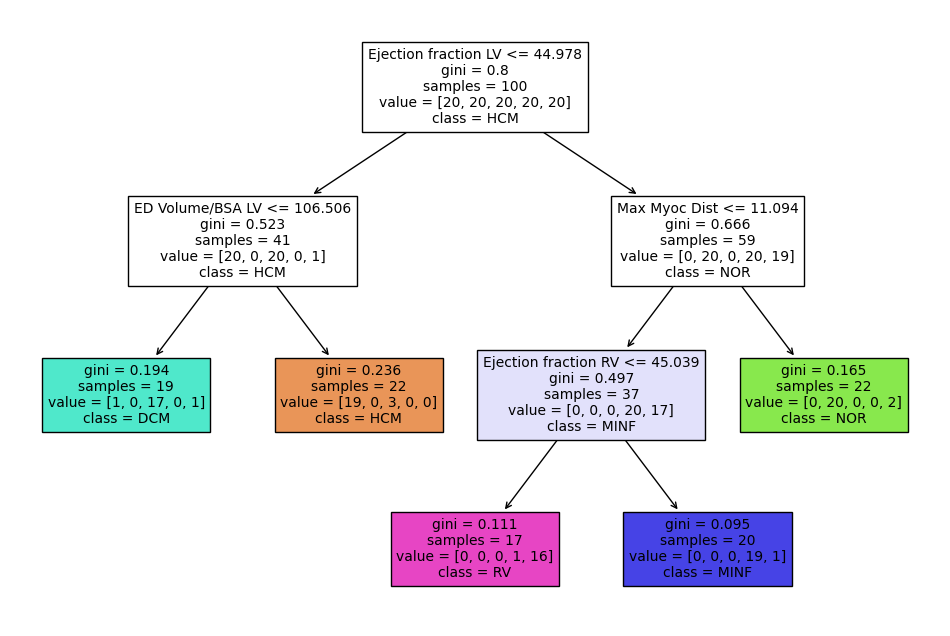

In [10]:
# Plot the Decision Tree Clasifier model
fig, ax = plt.subplots(figsize=(12, 8))
tree.plot_tree(clf, 
               feature_names=X_train.columns, 
               class_names=Y_train['Group'].unique(), 
               filled=True,
               fontsize=10)

plt.show()

In [11]:
X_test = []
Y_test = []

# Make X_test list by appending the features to the list
for i in range(len(test_dataset)): 
    X_test.append(calculate_features(test_dataset,i))
    
# Make Y_test list by appending the the labels to the list
for i in range(len(test_dataset)): 
    Y_test.append(test_dataset[i]["Group"])

# Make dataframe from the test data in the lists
X_test= pd.DataFrame(X_test)
Y_test= pd.DataFrame(Y_test)

# Make perdictions based on X_test data
Y_pred = clf.predict(X_test)

              precision    recall  f1-score   support

         DCM       0.71      1.00      0.83        10
         HCM       0.91      1.00      0.95        10
        MINF       1.00      0.50      0.67        10
         NOR       0.67      0.80      0.73        10
          RV       0.88      0.70      0.78        10

    accuracy                           0.80        50
   macro avg       0.83      0.80      0.79        50
weighted avg       0.83      0.80      0.79        50



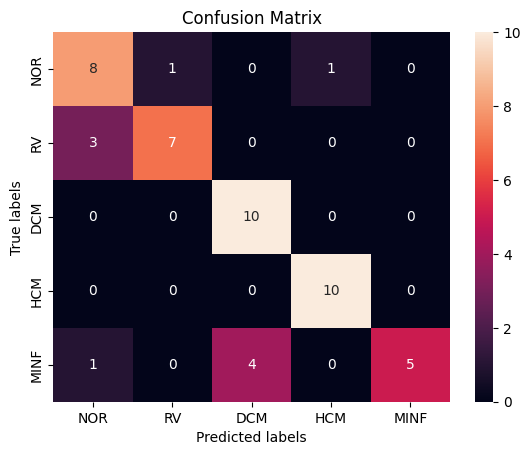

In [12]:
# Print Classification report
print(classification_report(Y_test, Y_pred))

# Plot confusion matrix
ax = plt.subplot()
sn.heatmap(confusion_matrix(Y_test, Y_pred, labels = ['NOR','RV','DCM','HCM','MINF']), annot=True)

# Labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['NOR','RV','DCM','HCM','MINF']); ax.yaxis.set_ticklabels(['NOR','RV','DCM','HCM','MINF']);

In [13]:
folder_path_ED = '/home/jovyan/Sietse_classification/data/ED_validatie_dataset'  # file path ED segmented mask
file_paths_ED = []  # list for saving file paths
count = 0

# Loop trough the all the files in the map and ath the file path to the list of file paths
for root, dirs, files in os.walk(folder_path_ED):
    for file in files:
        file_path_ED = os.path.join(root, file)  # Full file path
        file_paths_ED.append(file_path_ED)  # Append file path to list

        count = count + 1

# Sort the file paths to eventualy match the right mask to the right patient
file_paths_ED_sorted = sorted(file_paths_ED)


In [14]:
folder_path_ES = '/home/jovyan/Sietse_classification/data/ES_validatie_dataset'  # file path ES segmented mask
file_paths_ES = []   # list for saving file paths
count = 0

# Loop trough the all the files in the map and ath the file path to the list of file paths
for root, dirs, files in os.walk(folder_path_ES):
    for file in files:
        file_path_ES = os.path.join(root, file)  # Full file path
        file_paths_ES.append(file_path_ES)  # Append file path to list

        count = count + 1
        
# Sort the file paths to eventualy match the right mask to the right patient
file_paths_ES_sorted = sorted(file_paths_ES)


In [15]:
# Sort the file paths of ED_mask in the test dictionary to eventualy match the right mask to the right patient
sorted_list = sorted(test_dict_list, key=lambda x: x['ED_mask'])

# Change the GT mask path by the segmented mask path for ED_mask and ES_mask
for i in range(len(sorted_list)):
    sorted_list[i]['ED_mask'] = file_paths_ED_sorted[i]
    sorted_list[i]['ES_mask'] = file_paths_ES_sorted[i]
    
test_dict_seg_list = sorted_list

In [16]:
# Loads test dataset form the ground truth data
test_datasetseg=monai.data.Dataset(test_dict_seg_list,LoadData())

In [17]:
X_test = []
Y_test = []

# Make X_test list by appending the features to the list
for i in range(len(test_datasetseg)): 
    X_test.append(calculate_features(test_datasetseg,i))
    
# Make Y_test list by appending the the labels to the list
for i in range(len(test_datasetseg)): 
    Y_test.append(test_datasetseg[i]["Group"])

# Make dataframe from the test data in the lists
X_test= pd.DataFrame(X_test)
Y_test= pd.DataFrame(Y_test)

# Make perdictions based on X_test data
Y_pred = clf.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         DCM       0.50      0.30      0.37        10
         HCM       0.20      0.40      0.27        10
        MINF       0.17      0.30      0.21        10
         NOR       0.33      0.20      0.25        10
          RV       0.00      0.00      0.00        10

    accuracy                           0.24        50
   macro avg       0.24      0.24      0.22        50
weighted avg       0.24      0.24      0.22        50



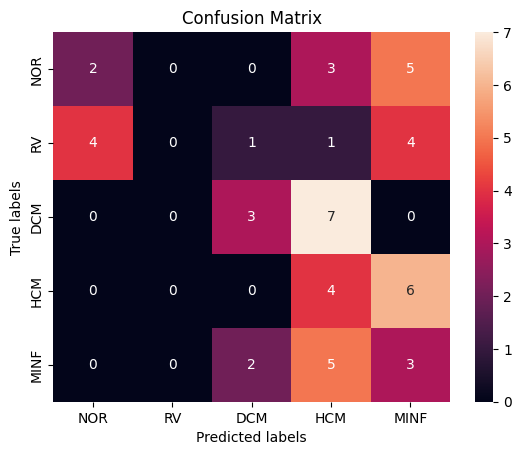

In [18]:
# Print Classification report
print(classification_report(Y_test, Y_pred))

# Plot confusion matrix
ax = plt.subplot()
sn.heatmap(confusion_matrix(Y_test, Y_pred, labels = ['NOR','RV','DCM','HCM','MINF']), annot=True)

# Labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['NOR','RV','DCM','HCM','MINF']); ax.yaxis.set_ticklabels(['NOR','RV','DCM','HCM','MINF']);


In [19]:
# Self made decision tree based on the features of the ACDC challenge 
# https://creatis.insa-lyon.fr/Challenge/acdc/databasesClassification.html
def DecTree(Data):
    if Data['Ejection fraction LV']>40: # Ejection fraction larger than 40%
        if Data['ED Volume/BSA LV']>100: # Normalized ED Volume of the left ventricle larger than 100 ml/m2
            sick='DCM'
        else:
            sick='MINF'
    else:
        if Data['ED Mass/BSA LV']>110: # Myocardial mass larger than 110 g/m2
            if Data['Max Myoc Dist'] > 15: # Myocardial maximal distance larger than 15mm
                sick='HCM'
            elif Data['ED Volume/BSA RV']>110 or Data['Ejection fraction RV']<40: 
                # Normalized ED Volume of the left ventricle larger than 110 ml/m2 or Ejection fraction smaller than 40%
                 sick='RV'
            else:
                sick='NOR'
        else:
            if Data['ED Volume/BSA RV']>110 or Data['Ejection fraction RV']<40:
                # Normalized ED Volume of the left ventricle larger than 110 ml/m2 or Ejection fraction smaller than 40%
                sick='RV'
            else:
                sick='NOR'
    return sick

In [20]:
y_true = []
y_pred = []

for i in range(len(test_dataset)): 
    y_true.append(test_dataset[i]["Group"])

for i in range(len(test_dataset)): 
    y_pred.append(DecTree(calculate_features(test_dataset,i)))


              precision    recall  f1-score   support

         DCM       0.70      0.70      0.70        10
         HCM       0.00      0.00      0.00        10
        MINF       0.17      0.30      0.21        10
         NOR       0.29      0.20      0.24        10
          RV       0.21      0.30      0.25        10

    accuracy                           0.30        50
   macro avg       0.27      0.30      0.28        50
weighted avg       0.27      0.30      0.28        50



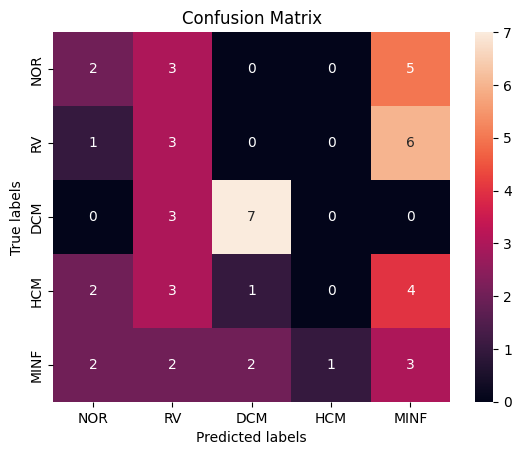

In [21]:
print(classification_report(y_true, y_pred))

ax = plt.subplot()
sn.heatmap(confusion_matrix(y_true, y_pred, labels = ['NOR','RV','DCM','HCM','MINF']), annot=True)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['NOR','RV','DCM','HCM','MINF']); ax.yaxis.set_ticklabels(['NOR','RV','DCM','HCM','MINF']);